In [ ]:
!pip install torchmetrics

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.tokenize import word_tokenize
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics import F1
from torchmetrics.functional import f1, recall
import matplotlib.pyplot as plt
from gensim.models import FastText

In [ ]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11] )
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets['tone'] = 0
all_tweets_data = pos_tweets.append(neg_tweets)
all_tweets_data['text']
all_tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [ ]:
def cleaning(data):
  data = data.lower()
  data = re.sub(r'[^А-яа-я-]+', ' ', data)
  return data

In [ ]:
all_tweets_data['cleaned'] = all_tweets_data.text.apply(lambda x: cleaning(x))
all_tweets_data['cleaned']

14515     л н харитонова скучная хочу домой хочу есть у ...
65537           день на берегу лет в море это очень жестко 
111251                            чем-то нравится домашняя 
31518     хочу смазливый фильм посмотреть что-то вроде д...
33327      я тебе больше скажу что у некоторых при всех ...
                                ...                        
419        да какая это поддержка просто это реально мер...
92342     киселев наверное на разрыв сейчас работает там...
11442      доброе утро супер мега бизнес центр на профес...
69344     збс может и мне подняться на крышу повертеть а...
62130      ну вы даете не замерзающие или ветра у вас та...
Name: cleaned, Length: 100000, dtype: object

In [ ]:
train_sentences, val_sentences = train_test_split(all_tweets_data, test_size=0.2)
#print(train_sentences['cleaned'])

80225    в школе эти производные легко решала сейчас ни...
88472     ага что бы кому-то мозги по-ебать что бы кто ...
56895                                    сладких и пошлых 
13216                                           это плохо 
57172    может ты прекратишь рт и избранить мои тупые т...
                               ...                        
94741                                          я и забыла 
83293         я про сашу он месяцев знает что я беременна 
16394     зашли на территорию только в нас обыскали раз...
39338            ты своих навестить что-ли пришла или как 
25654               наааааконец тепло еда только вот нету 
Name: cleaned, Length: 80000, dtype: object


In [ ]:
vocab = Counter()

for text in all_tweets_data['text']:
    vocab.update(text.split())
print('всего уникальных токенов:', len(vocab))
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab))

всего уникальных токенов: 287654
уникальных токенов, втретившихся больше 5 раз: 15105


In [ ]:
#создаем словарь с индексами symbol2id, для спецсимвола паддинга дефолтный индекс - 0
word2id = {'PAD':0}
for word in filtered_vocab:
    word2id[word] = len(word2id)
#обратный словарь для того, чтобы раскодировать последовательность
id2word = {i:word for word, i in word2id.items()}
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cpu')

In [ ]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self): 
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): 
        ids, y = list(zip(*batch))
        padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
        return padded_ids, y

In [ ]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
batch = next(iter(train_iterator))
#batch[1]

In [ ]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)
test_batch = next(iter(val_iterator))

torch.Size([1024, 25])

In [ ]:
batch, y = next(iter(val_iterator))

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=60, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.sec_conv = nn.Conv1d(in_channels=160, out_channels=40, kernel_size=3, padding='same')

        self.pooling = nn.MaxPool1d(kernel_size=2, stride=1)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=40, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        #print(feature_map_bigrams.shape)
        #print(feature_map_trigrams.shape)
        
        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        third_conv = self.dropout(self.pooling(self.relu(self.sec_conv(concat))))
        pooling1 = third_conv.max(2)[0]

        logits = self.hidden(pooling1) 
        logits = self.out(self.dropout(logits))      
        return logits

In [ ]:
model = CNN(len(id2word), 8)
output = model(batch)
#print(output)

In [ ]:
loss = nn.BCELoss()
loss(output, y)

tensor(0.7097, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(texts)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) 

In [ ]:
def learning(n_epochs, model, optimizer, criterion):
    for i in range(n_epochs):
        print(f'\nstarting Epoch {i}')
        print('Training...')
        epoch_loss = train(model, train_iterator, optimizer, criterion)
        losses.append(epoch_loss)
        print('\nEvaluating on train...')
        f1_on_train,_ = evaluate(model, train_iterator, criterion)
        f1s.append(f1_on_train.cpu())
        print('\nEvaluating on test...')
        f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
        losses_eval.append(epoch_loss_on_test)
        f1s_eval.append(f1_on_test.cpu())

In [ ]:
model = CNN(len(word2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()  
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(50):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)

In [ ]:
from tqdm import tqdm


def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in tqdm(enumerate(iterator)):
            preds = model(texts)  # делаем предсказания на тесте
            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp)+len(fn))
precision = len(tp)/(len(tp)+len(fp))
accuracy = (len(tp)+len(tn))/(len(fp) + len(fn) + len(tp) + len(tn))
f_score = 2 * precision * recall / (precision + recall)

20it [00:05,  3.85it/s]


In [ ]:
print(recall,precision,accuracy, f_score)

0.693026028213789 0.6868846002363135 0.6882 0.6899416477104144


In [ ]:
print('FN:', fn[:10])
print('FP:', fp[:10])

FN: ['идти нет на лекцию вроде староста не что делать буду думать до тех пор пока пара не начнется', 'новый год хочу думаю моментов будет много', 'два человека жд т или человек в лице джона и в мо м лице', 'ах как же хочется бокал вина и', 'через неделю в москве а через девять дней на быстрей бы', 'видно его мечта закончится только на подготовке ну а если серьезно то не верится но хотелось бы с', 'я тожи так думал а оказывается нит', 'спокойной ночи и не забывайте что на ночь нельзя смотреть бу', 'глупая маленькая девочка вот убивают такие люди вот что ты этим пытаешься сделать', 'когда у нас такой будет обед или ужин']
FP: ['всем доброе утро это разве зима дождь т как из', 'самые живут так далеко', 'андрей покидает пост программы орел и решка ну все', 'привет о хотя тебе насрать', 'са со самолет л к к ба деп', 'мои волнения на моих очеень', 'когда выходили из школы я просто мега упал порвал на ребята ржали надо мной всю дорогу х', 'суббота просто ужас', 'сегодня весь день буду смотрет

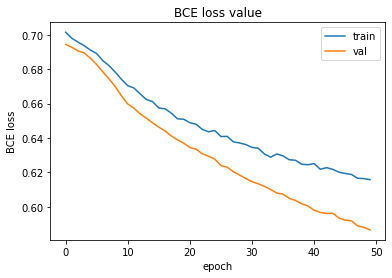

In [ ]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

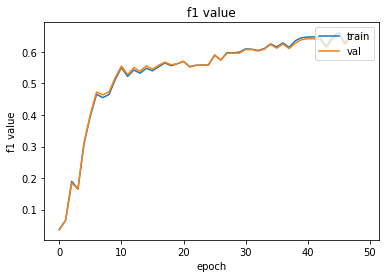

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

2 часть

In [ ]:
vocab_sym = Counter()
for symbol in all_tweets_data['cleaned']:
    vocab_sym.update(list(symbol))
print('всего уникальных символов:', len(vocab_sym))

filtered_vocab_sym = set()

for symb in vocab_sym:
    if vocab_sym[symb] > 5:
        filtered_vocab_sym.add(symb)
print('уникальных токенов, втретившихся больше 5 раз:', len(filtered_vocab_sym))

symb2id = {'PAD':0}

for symb in filtered_vocab_sym:
    symb2id[symb] = len(symb2id)
    
id2symbol = {i:symb for symb, i in symb2id.items()}

всего уникальных символов: 34
уникальных токенов, втретившихся больше 5 раз: 34


In [ ]:
class Sent_Word_TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, symb2id, DEVICE):
        self.dataset = dataset['cleaned'].values
        self.word2id = word2id
        self.symb2id = symb2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # пробелы тоже учитываются
        symbols = list(self.dataset[index])
        symbols_ids = torch.LongTensor([self.symb2id[symb] for symb in symbols if symb in self.symb2id])
        
        tokens = self.dataset[index].split()
        words_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        
        return words_ids, symbols_ids, y

    def collate_fn(self, batch):
        words_ids, symbols_ids, y = list(zip(*batch))
        padded_sym_ids = pad_sequence(symbols_ids, batch_first=True).to(self.device)
        padded_words_ids = pad_sequence(words_ids, batch_first=True).to(self.device)
        y = torch.Tensor(y).to(self.device)
        return padded_words_ids, padded_sym_ids, y

In [ ]:
train_dataset = Sent_Word_TweetsDataset(train_sentences, word2id, symb2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)
val_dataset = Sent_Word_TweetsDataset(val_sentences, word2id, symb2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
class Sent_Word_CNN(nn.Module):
    
    def __init__(self, words_vocab_size, symbols_vocab_size, symbols_embedding_dim):
        super().__init__()
        self.words_embedding = nn.Embedding(words_vocab_size, 5)
        self.words_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.words_hidden = nn.Linear(in_features=5, out_features=100)

        self.sym_embedding = nn.Embedding(symbols_vocab_size, symbols_embedding_dim)        
        self.sym_bigrams = nn.Conv1d(in_channels=symbols_embedding_dim, out_channels=60, kernel_size=2, padding='same')
        self.sym_trigrams = nn.Conv1d(in_channels=symbols_embedding_dim, out_channels=100, kernel_size=3, padding='same')        
        self.symbols_hidden = nn.Linear(in_features=160, out_features=100)
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=1)
        
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(200, 1)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sigmoid()

    def forward(self, words_seq, symb_seq):
        embedded_symb = self.sym_embedding(symb_seq)
        embedded_symb = embedded_symb.transpose(1,2)
        feature_map_bigrams = self.dropout(self.pooling(self.relu(self.sym_bigrams(embedded_symb))))
        feature_map_trigrams = self.dropout(self.pooling(self.relu(self.sym_trigrams(embedded_symb))))
        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        symbols_concat = torch.cat((pooling1, pooling2), 1)
        symb_vec = self.symbols_hidden(symbols_concat)
        
        embedded_words = self.words_embedding(words_seq) 
        m_embedded_words = torch.mean(embedded_words, dim=1)
        sent_vec = self.relu(self.dropout(self.words_hidden(m_embedded_words)))
        concat = torch.cat((symb_vec, sent_vec), 1)

        
        logits = self.hidden(concat) 
        logits = self.out(logits)      
        return logits

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах

    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (words_seq, symbols_seq, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        preds = model(words_seq, symbols_seq)  #прогоняем данные через модель
        loss = criterion(preds, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator) # возвращаем среднее значение лосса по всей выборке
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (words_seq, symbols_seq, ys) in enumerate(iterator):   
            preds = model(words_seq, symbols_seq)  # делаем предсказания на тесте
            loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val f1: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator) 

In [ ]:
model = Sent_Word_CNN(len(word2id), len(symb2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(20):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.775589359658105
Train loss: 0.7349624366595827
Train loss: 0.7193632044575431
Train loss: 0.7110289527198016
Train loss: 0.7055936471835987

Evaluating on train...
Val loss: 0.7339832825320107, Val f1: 0.38559651374816895
Val loss: 0.7085159071560564, Val f1: 0.37673547863960266
Val loss: 0.7007256096059625, Val f1: 0.3718792200088501
Val loss: 0.696677957550954, Val f1: 0.371798038482666
Val loss: 0.6943044888006674, Val f1: 0.36860522627830505

Evaluating on test...
Val loss: 0.9153825044631958, Val f1: 0.47238823771476746
Val loss: 0.7838407414300101, Val f1: 0.39998164772987366
Val loss: 0.7479343685236844, Val f1: 0.38861319422721863
Val loss: 0.7315058628718059, Val f1: 0.3781321942806244
Val loss: 0.7214286295991195, Val f1: 0.3754432797431946

starting Epoch 1
Training...
Train loss: 0.7327269273144859
Train loss: 0.7045007738573797
Train loss: 0.6936111788858067
Train loss: 0.6878229591806057
Train loss: 0.6827360818514953

Evaluatin

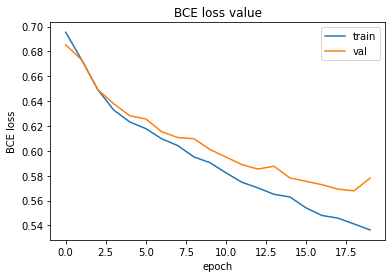

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

На 20 эпохах скачок (видимо, случилось переобучение), поставим поменьше

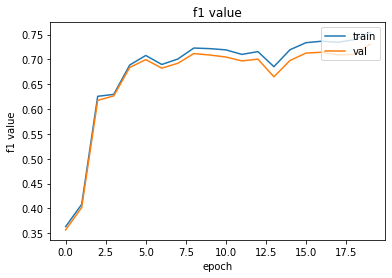

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
model = Sent_Word_CNN(len(word2id), len(symb2id), 8)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() 
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

losses = []
losses_eval = []
f1s = []
f1s_eval = []

for i in range(17):
    print(f'\nstarting Epoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    losses_eval.append(epoch_loss_on_test)
    f1s_eval.append(f1_on_test)


starting Epoch 0
Training...
Train loss: 0.7992709747382573
Train loss: 0.7484172212666479
Train loss: 0.7295017093420029
Train loss: 0.7200578592591367
Train loss: 0.713308227223319

Evaluating on train...
Val loss: 0.7364101665360587, Val f1: 0.6696382761001587
Val loss: 0.7107178055006882, Val f1: 0.6533588767051697
Val loss: 0.7025924677198584, Val f1: 0.6472249031066895
Val loss: 0.6984969347210254, Val f1: 0.6453640460968018
Val loss: 0.6960755079179197, Val f1: 0.6431303024291992

Evaluating on test...
Val loss: 0.9178418119748434, Val f1: 0.8310179710388184
Val loss: 0.7854924116815839, Val f1: 0.7173877954483032
Val loss: 0.7497152848677202, Val f1: 0.6818198561668396
Val loss: 0.7330591003100078, Val f1: 0.6710833311080933
Val loss: 0.7232071161270142, Val f1: 0.6636601686477661

starting Epoch 1
Training...
Train loss: 0.7316398237432752
Train loss: 0.7056166406335502
Train loss: 0.6957895105535333
Train loss: 0.6902341832548885
Train loss: 0.685789784064164

Evaluating on 

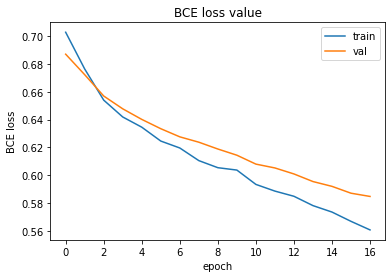

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('BCE loss value')
plt.ylabel('BCE loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Стало получше)

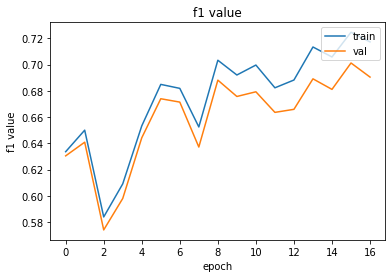

In [ ]:
import matplotlib.pyplot as plt
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in tqdm(enumerate(iterator)):
            preds = model(texts)  
            for pred, gold, text in zip(preds, ys, texts):
                text = ' '.join([id2word[int(word)] for word in text if word !=0])
                if round(pred.item()) > gold:
                    fp.append(text)
                elif round(pred.item()) < gold:
                    fn.append(text)
                elif round(pred.item()) == gold == 1:
                    tp.append(text)
                elif round(pred.item()) == gold == 0:
                    tn.append(text)
    return fp, fn, tp, tn

In [ ]:
fp, fn, tp, tn = predict(model, val_iterator)
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
accuracy = (len(tp)+len(tn))/(len(fp) + len(fn) + len(tp) + len(tn))
f_score = 2 * precision * recall / (precision + recall)
print(recall, precision, f_score,accuracy)
print('FN:', fn[:10])
print('FP:', fp[:10])


20it [00:08,  2.42it/s]

0.693026028213789 0.6868846002363135 0.6899416477104144 0.6865
FN: ['идти нет на лекцию вроде староста не что делать буду думать до тех пор пока пара не начнется', 'новый год хочу думаю моментов будет много', 'два человека жд т или человек в лице джона и в мо м лице', 'ах как же хочется бокал вина и', 'через неделю в москве а через девять дней на быстрей бы', 'видно его мечта закончится только на подготовке ну а если серьезно то не верится но хотелось бы с', 'я тожи так думал а оказывается нит', 'спокойной ночи и не забывайте что на ночь нельзя смотреть бу', 'глупая маленькая девочка вот убивают такие люди вот что ты этим пытаешься сделать', 'когда у нас такой будет обед или ужин']
FP: ['всем доброе утро это разве зима дождь т как из', 'самые живут так далеко', 'андрей покидает пост программы орел и решка ну все', 'привет о хотя тебе насрать', 'са со самолет л к к ба деп', 'мои волнения на моих очеень', 'когда выходили из школы я просто мега упал порвал на ребята ржали надо мной всю до

В FN попало много действительно negative, а в FP действительно positive. Плюс есть нейтральные. Кажется, это проблема в исходных данных (по крайней мере частично) и в том, что есть нейтральные, которые попадают везде по-разному.

> Блок с отступами

